In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import imageio
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

plt.style.use("seaborn-dark")

import sys
sys.path.append("../")
from rl.agents.q_agent import QAgent

In [2]:
xy = np.loadtxt('test3.csv', delimiter=",")
xy

array([[ 0.        ,  0.        ],
       [ 5.16601049,  5.16601049],
       [ 6.00383107,  0.        ],
       [ 6.74624857,  4.57775407],
       [ 3.35733921,  0.        ],
       [-1.05853617,  5.96498441],
       [-4.35714012,  0.        ],
       [-6.86150897,  4.52874046],
       [-5.43523257,  0.        ],
       [-3.67879414,  5.5770773 ],
       [ 1.59123526,  0.        ],
       [ 6.14561503,  4.81973175],
       [ 6.25961144,  0.        ],
       [ 6.37151786,  4.73136751],
       [ 2.10060475,  0.        ],
       [-3.05261581,  5.70879802],
       [-5.18350802,  0.        ],
       [-6.87221193,  4.52414698],
       [-4.66373125,  0.        ],
       [-1.7833208 ,  5.90061772],
       [ 2.95058046,  0.        ],
       [ 6.65413247,  4.61632878],
       [ 6.13436055,  0.        ],
       [ 5.56787524,  5.03121141],
       [ 0.57182085,  0.        ],
       [-4.70059122,  5.30951382],
       [-5.83448301,  0.        ],
       [-6.80663909,  4.55217701],
       [-3.73195449,

In [3]:
class Environment(object):
    
    def __init__(self, n_stops=32,method="angle_difference", **kwargs):
        
        print(f"Initialized Delivery Environment with {n_stops} random stops")
        print(f"Target metric for optimization is {method}")
              
        #Initializaiton 
        self.n_stops = n_stops
        self.action_space = self.n_stops
        self.observation_space = self.n_stops
        self.stops = []
        self.method = method
        
        
        #Generate Stops 
        self._generate_stops()
        self._generate_q_values()
        self.render
        self.reset()
        
        
    def _generate_stops(self):
        
        xy = np.loadtxt('test3.csv', delimiter=",")
        self.x = xy[:,0]
        self.y = xy[:,1]
        
    def _generate_q_values(self):
        xy = np.column_stack([self.x, self.y])
        mat = np.zeros((len(xy), len(xy)))

        for i in range(len(xy)):
            for j in range(len(xy)):
                if (xy[j][1] - xy[i][1]) == 0:
                    mat[i][j] = -100
                elif (xy[j][1] != 0) and (xy[i][1] != 0):
                    mat[i][j] = -100
                else:
                    # Calculate the angle of incidence
                    angle_of_incidence = np.arctan2(xy[j][1] - xy[i][1], xy[j][0] - xy[i][0])

                    # Calculate the angle of reflection (assuming reflection on x-axis)
                    angle_of_reflection = -angle_of_incidence

                    # Calculate the absolute difference between angle of incidence and angle of reflection
                    angle_diff = abs(angle_of_reflection - angle_of_incidence)

                    # Assign the angle difference as the Q-value
                    mat[i][j] = angle_diff

        # Normalize the matrix using Min-Max scaling
        mat_normalized = (mat - np.min(mat)) / (np.max(mat) - np.min(mat))

        self.q_stops = mat_normalized
        
    def render(self,return_img = False):
        
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title("Paths")

        # Show stops
        ax.scatter(self.x,self.y,c = "red",s = 50)

        # Show START
        if len(self.stops)>0:
            xy = self._get_xy(initial = True)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("START",xy=xy,xytext=xytext,weight = "bold")

        # Show itinerary
        if len(self.stops) > 1:
            ax.plot(self.x[self.stops],self.y[self.stops],c = "blue",linewidth=1,linestyle="--")
            
            # Annotate END
            xy = self._get_xy(initial = False)
            xytext = xy[0]+0.1,xy[1]-0.05
            ax.annotate("END",xy=xy,xytext=xytext,weight = "bold")

        plt.xticks([])
        plt.yticks([])
        
        if return_img:
            # From https://ndres.me/post/matplotlib-animated-gifs-easily/
            fig.canvas.draw_idle()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image
        else:
            plt.show()
    
    def reset(self):

        # Stops placeholder
        self.stops = [0]

        # Random first stop
        return self.stops[-1]

    def step(self,destination):

        # Get current state
        state = self._get_state()
        new_state = destination
        
        # If attempting to traverse a large negative value transition, reset the new_state to the current state
        if self.q_stops[state, new_state] == 0.:
            new_state = state

        # Get reward for such a move
        reward = self._get_reward(state,new_state)

        # Append new_state to stops
        self.stops.append(destination)
        done = len(self.stops) == self.n_stops

        return new_state,reward,done

    def _get_state(self):
        return self.stops[-1]
 

    def _get_xy(self,initial = False):
        state = self.stops[0] if initial else self._get_state()
        x = self.x[state]
        y = self.y[state]
        return x,y


    def _get_reward(self, state, new_state):
        base_reward = self.q_stops[state,new_state]
        return base_reward


def run_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()

    max_step = env.n_stops
    
    episode_reward = 0.
    seq = [0,1]
    # Remember the states
    agent.remember_state(s)
    # Take the action, and get the reward from environment
    s_next,r,done = env.step(1)

    # Tweak the reward
    r = r
    if verbose: print(s_next,r,done)

    # Update our knowledge ein the Q-table
    agent.train(s,1,r,s_next)

    # Update the caches
    episode_reward += r
    s = s_next
    
    
    i = 0
    while i < max_step-1:

        # Remember the states
        agent.remember_state(s)

        # Choose an action
        a = agent.act(s)
        
        seq.append(a)
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(a)
        
        # Tweak the reward
        r = r
        
        if verbose: print(s_next,r,done)
        
        # Update our knowledge in the Q-table
        agent.train(s,a,r,s_next)
        
        # Update the caches
        episode_reward += r
        s = s_next
        
        # If the episode is terminated
        i += 1
        if done:
            break
            
    return env,agent,episode_reward, seq



class DeliveryQAgent(QAgent):

    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.reset_memory()

    def act(self,s):
        
        # Get Q Vector
        q = np.copy(self.Q[s,:])

        # Avoid already visited states
        q[self.states_memory] = -np.inf
    
        if np.random.rand() > self.epsilon:
            #Localised Algo, Commented
            #a_candidates = [x for x in range(self.actions_size) if x not in self.states_memory]
            #min_sub = 0.
            #a = None
            #for candidate in a_candidates:
            #    diff = rewards-candidate
            #    if diff<min_sub:
            #        min_sub = diff
            #        a = candidate 
            a = np.argmax(q)    
        else:
            a = np.random.choice([x for x in range(self.actions_size) if x not in self.states_memory])

        return a



    def remember_state(self,s):
        self.states_memory.append(s)

    def reset_memory(self):
        self.states_memory = []



def run_n_episodes(env,agent,name="training32.gif",n_episodes=1000,render_each=5,fps=10):

    # Store the rewards
    rewards = []
    imgs = []
    seq2 = []

    # Experience replay
    for i in tqdm_notebook(range(n_episodes)):

        # Run the episode
        env,agent,episode_reward,seq = run_episode(env,agent,verbose = 0)
        rewards.append(episode_reward)
        seq2.append(seq)
            
        if i % render_each == 0:
            img = env.render(return_img = True)
            imgs.append(img)
    
    
    # Show rewards
    plt.figure(figsize = (15,3))
    plt.title("Rewards over training")
    plt.plot(rewards)
    plt.show()

    # Save imgs as gifq
    imageio.mimsave(name,imgs,fps = fps)

    return env,agent,rewards,seq2

In [4]:
env = Environment()
print(env.q_stops)

Initialized Delivery Environment with 32 random stops
Target metric for optimization is angle_difference
[[0.         0.96166599 0.         ... 0.97553344 0.         0.95788741]
 [0.99141039 0.         0.97349369 ... 0.         0.98063608 0.        ]
 [0.         0.97958269 0.         ... 0.9909056  0.         0.97309106]
 ...
 [0.97754294 0.         0.96217077 ... 0.         0.96604318 0.        ]
 [0.         0.9724403  0.         ... 0.9870332  0.         0.96604318]
 [0.99518897 0.         0.97998532 ... 0.         0.9870332  0.        ]]


In [5]:
def run_corr_episode(env,agent,verbose = 1):

    s = env.reset()
    agent.reset_memory()
    arr = np.arange(1,26)

    episode_reward = 0

    for i in arr:
                  
        # Remember the states
        agent.remember_state(s)
        
        # Take the action, and get the reward from environment
        s_next,r,done = env.step(i)

        # Tweak the reward
        r = r

        if verbose: print(s_next,r,done)

        # Update our knowledge ein the Q-table
        agent.train(s,i,r,s_next)

        # Update the caches
        episode_reward += r
        s = s_next

        # If the episode is terminated
        if done:
            break
            
    return env,agent,episode_reward


In [6]:
#Correct Reward Path For Light
env = Environment(n_stops = 26,method = "angle_difference" )
agent = DeliveryQAgent(env.observation_space,env.action_space)
p, q, r = run_corr_episode(env,agent)
print("Iteration Reward = ", r)

Initialized Delivery Environment with 26 random stops
Target metric for optimization is angle_difference
1 0.9616659876993171 False
2 0.9734936880274835 False
3 0.9734936880274835 False
4 0.9886053391582535 False
5 0.9886053391582535 False
6 0.9861034464493232 False
7 0.9861034464493232 False
8 0.9707607553399199 False
9 0.9707607553399199 False
10 0.9622018604269909 False
11 0.9622018604269909 False
12 0.9760904014056903 False
13 0.9760904014056903 False
14 0.9904426907613249 False
15 0.9904426907613249 False
16 0.9833030001694099 False
17 0.9833030001694099 False
18 0.9679389158356702 False
19 0.9679389158356702 False
20 0.9637351732991091 False
21 0.9637351732991091 False
22 0.97866131797623 False
23 0.97866131797623 False
24 0.9913440001060684 False
25 0.9913440001060684 True
Iteration Reward =  24.427027165610266


Initialized Delivery Environment with 26 random stops
Target metric for optimization is angle_difference
Training with hyperparameters: {'epsilon': 0.2, 'epsilon_decay': 0.8, 'gamma': 0.7, 'lr': 0.1}


C:\Users\PC\AppData\Local\Temp/ipykernel_14188/3288310713.py:245: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/500 [00:00<?, ?it/s]

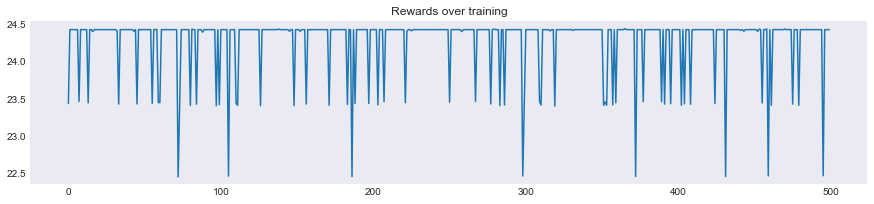

Mean reward over the last 100 episodes: 24.28815444298959
Training with hyperparameters: {'epsilon': 0.4, 'epsilon_decay': 0.9, 'gamma': 0.8, 'lr': 0.3}


C:\Users\PC\AppData\Local\Temp/ipykernel_14188/3288310713.py:245: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_episodes)):


  0%|          | 0/500 [00:00<?, ?it/s]

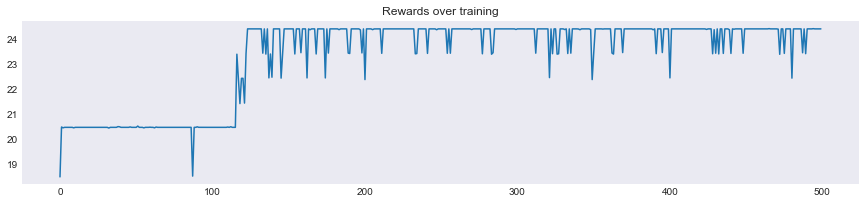

In [ ]:
def grid_search_hyperparameters(env, hyperparameter_grid, n_episodes=500, render_each=10, fps=10):
    best_hyperparameters = None
    best_mean_reward = float("-inf")
    rewards_by_hyperparameters = {}

    # Loop through all possible combinations of hyperparameters
    for hyperparameters in hyperparameter_grid:
        print(f"Training with hyperparameters: {hyperparameters}")

        # Create the agent with the current set of hyperparameters
        agent = DeliveryQAgent(states_size=env.observation_space, actions_size=env.action_space, 
                               epsilon=hyperparameters['epsilon'],
                               epsilon_decay=hyperparameters['epsilon_decay'],
                               gamma=hyperparameters['gamma'],
                               lr=hyperparameters['lr'])

        # Train the agent and get rewards
        _, _, rewards,_ = run_n_episodes(env, agent, n_episodes=n_episodes, render_each=render_each, fps=fps)
        rewards_by_hyperparameters[str(hyperparameters)] = rewards

        # Calculate the mean reward over the last episodes
        mean_reward = np.mean(rewards[-100:])
        print(f"Mean reward over the last 100 episodes: {mean_reward}")

        # Check if it's the best set of hyperparameters so far
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            best_hyperparameters = hyperparameters

    print("Grid search complete.")
    print("Best Hyperparameters:")
    print(best_hyperparameters)

    return best_hyperparameters, rewards_by_hyperparameters


if __name__ == "__main__":
    # Define the hyperparameter grid with the range of values to search through
    hyperparameter_grid = [
        {"epsilon": 0.2, "epsilon_decay": 0.8, "gamma": 0.7, "lr": 0.1},
        {"epsilon": 0.4, "epsilon_decay": 0.9, "gamma": 0.8, "lr": 0.3},
        {"epsilon": 0.6, "epsilon_decay": 0.95, "gamma": 0.9, "lr": 0.5},
        {"epsilon": 0.8, "epsilon_decay": 0.95, "gamma": 0.9, "lr": 0.7}
    ]

    # Create the environment
    env = Environment(n_stops=26)
    
    # Perform grid search hyperparameter tuning
    best_hyperparameters, rewards_by_hyperparameters = grid_search_hyperparameters(env, hyperparameter_grid)

    # Train the final agent with the best hyperparameters
    agent = DeliveryQAgent(states_size=env.observation_space, actions_size=env.action_space, 
                           epsilon=best_hyperparameters['epsilon'],
                           epsilon_decay=best_hyperparameters['epsilon_decay'],
                           gamma=best_hyperparameters['gamma'],
                           lr=best_hyperparameters['lr'])
    a,b,c,d = run_n_episodes(env, agent, n_episodes=1000, render_each=20, fps=10)


In [ ]:
from IPython.display import Image
Image(filename="training32.gif")

In [ ]:
def are_lists_equal(list1, list2):
    # Check if both lists have the same length
    if len(list1) != len(list2):
        return False
    
    # Compare each element of the lists
    for item1, item2 in zip(list1, list2):
        if item1 != item2:
            return False
    
    # If all elements are equal, return True
    return True

def check_lists_in_list(list_of_lists, arbitrary_list):
    for sublist in list_of_lists:
        if are_lists_equal(sublist, arbitrary_list):
            print("Found a match:", sublist)

# Example usage:
list_of_lists = np.array(d)
arbitrary_list = np.arange(0, 2)

check_lists_in_list(list_of_lists, arbitrary_list)

In [ ]:
result = c== r
count_true = np.count_nonzero(result)
count_true

In [ ]:
result = c> r
count_true = np.count_nonzero(result)
count_true

In [ ]:
env.reset()
for i in np.array(d)[700]:
    env.step(i)
env.render()